# Cross-entropy method on CartPole (Keras)

Here I modify the "01a Cross-entropy method , Cartpole (PyTorch)" notebook, so that I change it from PyTorch to Keras.

Cross-entropy method is applied for CartPole environment from OpenAI gym, with Keras. Cross-entropy method is :
- policy-based method
- on-policy method

The PyTorch code was  based on the book: Deep Reinforcement Learning Hands-On, 2nd edition, from Packt publishing, by Maxim Lapan. 

## 1. Import packages

In [1]:
import gym
from collections import namedtuple
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## 2. Build the model

In [2]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [3]:
class Net(tf.keras.Model):

  def __init__(self, hidden_size, n_actions):
    super(Net, self).__init__()
    self.dense1=layers.Dense(hidden_size,activation="relu")                             
    self.dense2=layers.Dense(n_actions, activation='softmax')

  def call(self,inputs):
    x=self.dense1(inputs)
    return self.dense2(x)

## 3. Play the Cartpole and create batches with Episodes

In [4]:
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [5]:
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()
    while True:
        obs_v=np.expand_dims(obs,0)
        act_probs_v = net(obs_v)
        act_probs=act_probs_v.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

## 4. Select only the episodes with best rewards for training

In [6]:
# Remove those episodes from the batch where reward is not within the best percentile
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = tf.constant(train_obs, dtype=tf.float32)
    #train_act_v = tf.constant(train_act, dtype=tf.int32)
    train_act_v=tf.one_hot(train_act, n_actions)
    return train_obs_v, train_act_v, reward_bound, reward_mean


## 5. Play the game to create batch of transitions and train the network with the best episodes

In [7]:
env = gym.make("CartPole-v0")
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

net = Net(HIDDEN_SIZE, n_actions)
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

net.compile(optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy'])

reward_means=[]
rw_boundaries=[]
losses=[]

for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    history=net.fit(obs_v, acts_v, epochs=1,verbose=0)
    if reward_m > 199:
        print("Solved!")
        break
    loss=history.history['loss'][-1]
    print(f"{iter_no}: loss={loss:.4f}, reward_mean={reward_m:.2f}, rw_bound={reward_b:.2f}")
    reward_means.append(reward_m)
    rw_boundaries.append(reward_b)
    losses.append(loss)

0: loss=0.6850, reward_mean=23.44, rw_bound=30.00
1: loss=0.6900, reward_mean=21.81, rw_bound=24.50
2: loss=0.6793, reward_mean=21.50, rw_bound=21.50
3: loss=0.6803, reward_mean=28.19, rw_bound=32.00
4: loss=0.6753, reward_mean=25.56, rw_bound=32.00
5: loss=0.6832, reward_mean=20.88, rw_bound=23.50
6: loss=0.6620, reward_mean=34.50, rw_bound=39.00
7: loss=0.6585, reward_mean=38.31, rw_bound=43.00
8: loss=0.6663, reward_mean=36.06, rw_bound=43.50
9: loss=0.6461, reward_mean=35.25, rw_bound=38.00
10: loss=0.6487, reward_mean=39.75, rw_bound=50.50
11: loss=0.6464, reward_mean=36.44, rw_bound=34.00
12: loss=0.6419, reward_mean=45.44, rw_bound=47.50
13: loss=0.6512, reward_mean=44.31, rw_bound=48.50
14: loss=0.6489, reward_mean=54.56, rw_bound=61.50
15: loss=0.6341, reward_mean=54.19, rw_bound=66.50
16: loss=0.6311, reward_mean=54.31, rw_bound=59.50
17: loss=0.6286, reward_mean=70.38, rw_bound=86.50
18: loss=0.6279, reward_mean=48.50, rw_bound=56.50
19: loss=0.6238, reward_mean=67.31, rw_bo

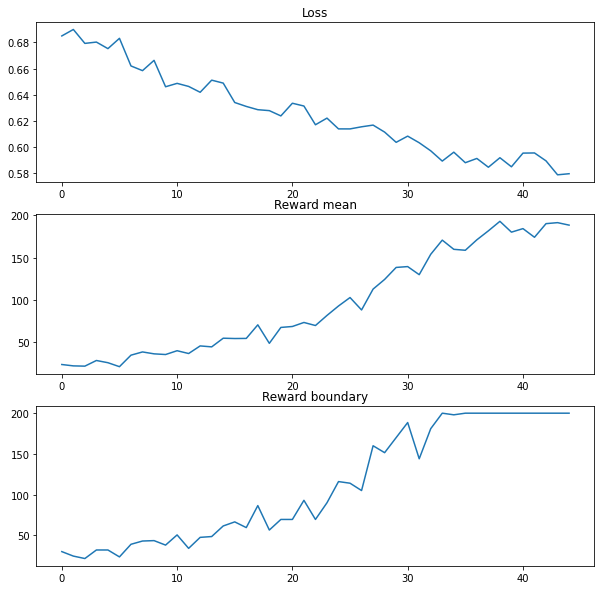

In [10]:
plt.figure(figsize=(10, 10))
charts=[losses,reward_means,rw_boundaries]
titles=['Loss','Reward mean','Reward boundary']
for i, (chart, title) in enumerate(zip(charts,titles)):
  ax=plt.subplot(3,1,i+1)
  plt.plot(chart)
  plt.title(title)